<a href="https://colab.research.google.com/github/chizuchizu/IOAI/blob/main/Task3/CV_scoring_chizu_001_animal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Scoring
The target score is accuracy, judging by whether our detector sees the expected animal and doesn't see others. 50% of the score comes from zebra/giraffe classes and 50% from other objects.

For this notebook, you are expected to change `model_url` and run it end-to-end. You may want to extend prompts/labels for deeper evaluation. You don't need to change anything else.

The final standing will be judged by a similar script; it may differ in details but will follow the same approach. The detector may not always be precise; for the final standing, we will employ several modifications to alleviate the effect and provide fair judgment.

In [2]:
model_url = 'ioai2024japan/chizu_028_014_alpha_1.5_yolo_loss'

In [3]:
import importlib

if importlib.util.find_spec('diffusers') is None:
    !pip install diffusers transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [4]:
import torch
from diffusers import DiffusionPipeline
from transformers import YolosImageProcessor, YolosForObjectDetection
import numpy as np

from google.colab import userdata

torch.set_grad_enabled(False)  # disable all gradients, as we do only inference

device = 'cuda'
seed = 42

added_classes = ["bird", "cat", "dog", "horse", "cow", "elephant"]

new_classes = ["giraffe", "zebra", "bear", "sheep"]
new_classes += added_classes

prompts = [
    ["A curious zebra standing tall in a lush African savanna at sunrise, with acacia tree,s in the background.", "giraffe"],
    ["Next to a medieval castle, a regal zebra observes the knights and a drawbridge.", "giraffe"],
    ["Wearing a scarf, a fashionable giraffe strolls through a bustling city street with skyscrapers.", "zebra"],
    ["Running along a sandy beach, a playful giraffe enjoys the palm trees, ocean waves, and a bright sunset.", "zebra"],
    ["By a serene lakeside, a relaxed bear drinks water with mountains and a clear blue sky in the background.", "bear"],
    ["In a snowy forest, a cozy bear stands under snow-covered trees, enjoying the gentle snowfall.", "bear"],
    ["Partially hidden in a dense tropical rainforest, an adventurous sheep peeks through leafy plants.", "sheep"],
    ["A sleek sheep with modern accessories navigates a futuristic city with flying cars and neon lights.", "sheep"],
    # added
]
for class_ in added_classes:
    prompts.append([f"By a serene lakeside, a relaxed {class_} drinks water with mountains and a clear blue sky in the background.", class_])
    prompts.append([f"In a snowy forest, a cozy {class_} stands under snow-covered trees, enjoying the gentle snowfall.", class_])
    prompts.append([f"Partially hidden in a dense tropical rainforest, an adventurous {class_} peeks through leafy plants.", class_])
    prompts.append([f"A sleek {class_} with modern accessories navigates a futuristic city with flying cars and neon lights.", class_])

prompts

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

[['A curious zebra standing tall in a lush African savanna at sunrise, with acacia tree,s in the background.',
  'giraffe'],
 ['Next to a medieval castle, a regal zebra observes the knights and a drawbridge.',
  'giraffe'],
 ['Wearing a scarf, a fashionable giraffe strolls through a bustling city street with skyscrapers.',
  'zebra'],
 ['Running along a sandy beach, a playful giraffe enjoys the palm trees, ocean waves, and a bright sunset.',
  'zebra'],
 ['By a serene lakeside, a relaxed bear drinks water with mountains and a clear blue sky in the background.',
  'bear'],
 ['In a snowy forest, a cozy bear stands under snow-covered trees, enjoying the gentle snowfall.',
  'bear'],
 ['Partially hidden in a dense tropical rainforest, an adventurous sheep peeks through leafy plants.',
  'sheep'],
 ['A sleek sheep with modern accessories navigates a futuristic city with flying cars and neon lights.',
  'sheep'],
 ['By a serene lakeside, a relaxed bird drinks water with mountains and a clear

In [6]:
pipe = DiffusionPipeline.from_pretrained(
    model_url, torch_dtype=torch.float16, safety_checker=None, requires_safety_checker=False, token=userdata.get("hf_read")
)
pipe.set_progress_bar_config(disable=True)
pipe.to(device)

def generate(prompt):
    image = pipe(
        prompt=prompt, num_inference_steps=50, guidance_scale=8.5,
        generator=torch.Generator(device=device).manual_seed(seed)
    ).images[0]

    return image

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/672 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/780 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/374 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/712 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/791 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [7]:

model = YolosForObjectDetection.from_pretrained('hustvl/yolos-tiny')
image_processor = YolosImageProcessor.from_pretrained("hustvl/yolos-tiny")
model.to(device)

def detect(image):
    inputs = image_processor(images=image, return_tensors="pt").to(device)
    outputs = model(**inputs)
    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.6, target_sizes=target_sizes)[0]
    objects = [model.config.id2label[idx.item()] for idx in results['labels']]
    return objects


config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/26.0M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

In [28]:
def is_correct(objects, name):
    # name = new_classes[label]
    print(name)
    print(set(objects).intersection(set(new_classes)))
    print(name in set(objects).intersection(set(new_classes)))
    return name in set(objects).intersection(set(new_classes))


In [29]:
import matplotlib.pyplot as plt
scores = []
for prompt, name in prompts:
    image = generate(prompt)
    print(prompt)
    image.show()
    plt.show()
    objects = detect(image)
    print(objects)
    scores.append(is_correct(objects, name))


A curious zebra standing tall in a lush African savanna at sunrise, with acacia tree,s in the background.
['giraffe', 'giraffe', 'giraffe', 'giraffe', 'giraffe', 'giraffe']
giraffe
{'giraffe'}
True
Next to a medieval castle, a regal zebra observes the knights and a drawbridge.
['giraffe', 'giraffe', 'giraffe']
giraffe
{'giraffe'}
True
Wearing a scarf, a fashionable giraffe strolls through a bustling city street with skyscrapers.
['car', 'car', 'zebra', 'car', 'zebra', 'car', 'zebra', 'zebra', 'zebra', 'car', 'zebra', 'person', 'car', 'zebra', 'car', 'zebra', 'car', 'car', 'zebra', 'zebra', 'car']
zebra
{'zebra'}
True
Running along a sandy beach, a playful giraffe enjoys the palm trees, ocean waves, and a bright sunset.
['zebra', 'zebra', 'zebra']
zebra
{'zebra'}
True
By a serene lakeside, a relaxed bear drinks water with mountains and a clear blue sky in the background.
['bear', 'bear', 'bear', 'bear', 'bear']
bear
{'bear'}
True
In a snowy forest, a cozy bear stands under snow-covered 

In [11]:
print(f"The score for {model_url} is {np.mean(scores)}")

The score for ioai2024japan/chizu_028_014_alpha_1.5_yolo_loss is 0.96875


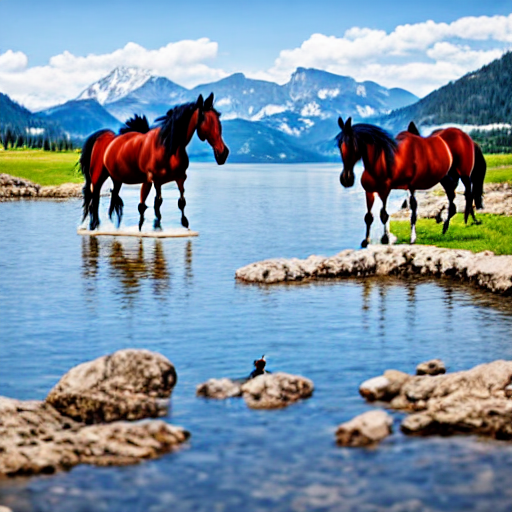

In [32]:
image = generate(prompts[-12][0])
image

In [15]:
inputs = image_processor(images=image, return_tensors="pt").to(device)
outputs = model(**inputs)
target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.6, target_sizes=target_sizes)[0]
objects = [model.config.id2label[idx.item()] for idx in results['labels']]

In [16]:
outputs.logits[0, :, :-1].argmax(1)

tensor([19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,  1, 19, 19, 19,
        19, 19, 19, 19,  1, 19, 19, 19, 19,  1, 19, 19, 19,  1, 19, 19, 19, 19,
        19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
        19, 19, 19, 19, 19,  1, 19, 19, 19, 19, 19, 19,  1, 19, 19, 19, 19, 19,
        19, 19, 19, 19, 19, 19, 19,  1, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
        19, 19, 19, 19, 19, 19, 19, 19, 19, 19], device='cuda:0')

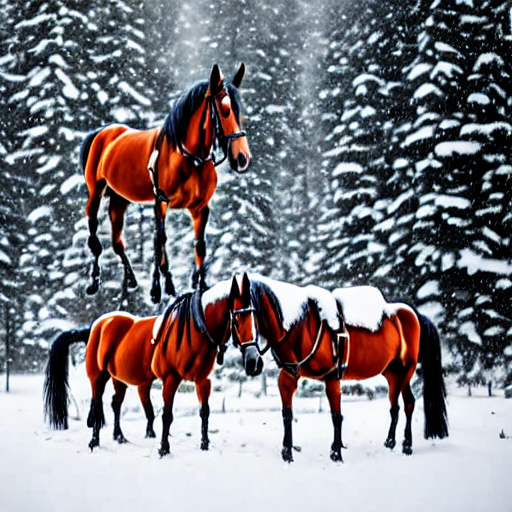

In [17]:
image